## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.


1. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_name = "raw_data/data_000637.txt"
df = pd.read_csv(file_name, nrows=10000)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


2\. Find out the value of 'x'

In [2]:
'''
orbit_cnt = df.loc[0,'ORBIT_CNT']
ordered_Bx = [[df.loc[0,'BX_COUNTER']]]
max_bx = []
               
for i in range(1,len(df)):
    if orbit_cnt == df.loc[i,'ORBIT_CNT']:
        ordered_Bx[len(ordered_Bx)-1].append( df.loc[i,'BX_COUNTER'] )
    else:
        orbit_cnt = df.loc[i,'ORBIT_CNT']
        ordered_Bx[len(ordered_Bx)-1].sort()
        max_bx.append(ordered_Bx[len(ordered_Bx)-1][-1])
        
        ordered_Bx.append([df.loc[i,'BX_COUNTER']])

print(ordered_Bx[109])
'''

x = df.loc[:, 'BX_COUNTER'].max()
print('X is equal to ',x)

X is equal to  3563


3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

In [3]:
# Time computed considering that BX_counter is updated every 25ns and ORBIT_CNT every x BX_COUNTER

full_cycles = df.loc[len(df)-1,'ORBIT_CNT'] - df.loc[0,'ORBIT_CNT'] - 1
start_bx = df.loc[0, 'BX_COUNTER']
finish_bx = df.loc[len(df)-1, 'BX_COUNTER']
start_tdc = df.loc[0, 'TDC_MEAS']
finish_tdc = df.loc[len(df)-1, 'TDC_MEAS']

total_time = full_cycles*x*25 + (x-start_bx)*25 + finish_bx*25 + (30-start_tdc)*25/30 + finish_tdc*25/30
print('Total time:', total_time,'ns')

Total time: 8867589.166666668 ns


4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

In [4]:
time = np.zeros(len(df))
for i in range(1,len(df)):
    orbit_time = (df.loc[i,'ORBIT_CNT']-df.loc[i-1,'ORBIT_CNT'])*x*25
    bx_time = (df.loc[i,'BX_COUNTER']-df.loc[i-1,'BX_COUNTER'])*25
    tdc_time = (df.loc[i,'TDC_MEAS']-df.loc[i-1,'TDC_MEAS'])*25/30
    time[i] = orbit_time + bx_time + tdc_time + time[i-1]

df['TIME'] = pd.Series(time, index=df.index)
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
0,1,0,123,3869200167,2374,26,0.000000
1,1,0,124,3869200167,2374,27,0.833333
2,1,0,63,3869200167,2553,28,4476.666667
3,1,0,64,3869200167,2558,19,4594.166667
4,1,0,64,3869200167,2760,25,9649.166667


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

In [5]:
df.loc[:,'HEAD'] = np.random.randint(2, size=len(df))
df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
0,1,0,123,3869200167,2374,26,0.000000
1,0,0,124,3869200167,2374,27,0.833333
2,0,0,63,3869200167,2553,28,4476.666667
3,1,0,64,3869200167,2558,19,4594.166667
4,0,0,64,3869200167,2760,25,9649.166667


6\. Create a new DataFrame with only the raws with HEAD=1

In [6]:
df_mod = df[df['HEAD']==1]
df_mod.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
0,1,0,123,3869200167,2374,26,0.000000
3,1,0,64,3869200167,2558,19,4594.166667
5,1,0,63,3869200167,2762,4,9681.666667
7,1,0,139,3869200167,2776,0,10028.333333
8,1,0,62,3869200167,2774,21,9995.833333


7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

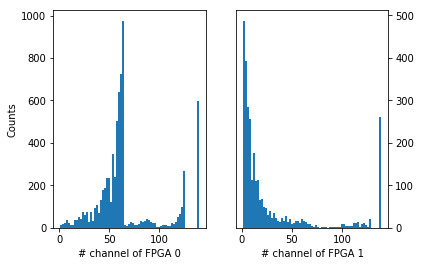

In [7]:
# Divide data between FPGA 0 and 1
df_0 = df[df['FPGA']==0]
df_1 = df[df['FPGA']==1]

n_channels_0 = df_0.loc[:,'TDC_CHANNEL'].max()
n_channels_1 = df_1.loc[:,'TDC_CHANNEL'].max()

# Plot counts for each channel
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.hist(df_0.loc[:,'TDC_CHANNEL'], bins=n_channels_0//2)
ax1.hist(df_1.loc[:,'TDC_CHANNEL'], bins=n_channels_1//2)
ax0.set_ylabel('Counts')
ax1.yaxis.tick_right()
ax0.set_xlabel('# channel of FPGA 0')
ax1.set_xlabel('# channel of FPGA 1')
plt.show()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [8]:
channels_df = df.groupby('TDC_CHANNEL')
channel_count = {i:channels_df.groups[i].size for i in channels_df.groups}
noisy_ch = sorted(channel_count, key=channel_count.get)[::-1]
print('Top 3 noisiest channels are (in order): ', noisy_ch[:3])

Top 3 noisiest channels are (in order):  [139, 63, 64]


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [9]:
# Counting unique orbits
orbit_df = df.groupby('ORBIT_CNT')
print('Total Number of unique orbits is', len(orbit_df.groups))

# Counting unique orbits with meas in TDC_CHANNEL=139
multigroup_df = df.groupby(['TDC_CHANNEL', 'ORBIT_CNT'])
orbit_in_139 = {i:multigroup_df.groups[i] for i in multigroup_df.groups.keys() if i[0]==139}
print('Total Number of unique orbits with a measure in TDC_CH = 139 is', len(orbit_in_139))

Total Number of unique orbits is 101
Total Number of unique orbits with a measure in TDC_CH = 139 is 101
